In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os

In [2]:
# for the sake of reproducibility 

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# Name generation

Lets try to do something useful with our RNNs.

_Teaser:_

* It is hard to choose a name for a variable. But its much harder to choose a name for a person.
  So lets make neural net do it instead!
* Dataset consists of 8 thousand people names from different cultures all around the world.
* Our toy task be to train a model to generate a name.

In [3]:
start_token = " "

with open("names.txt") as f:
    names = f.readlines()
    names = [start_token + name.lower() for name in names]

In [4]:
print('n samples = ', len(names))
for x in names[::1000]:
    print(x.strip().capitalize())

n samples =  7944
Abagael
Claresta
Glory
Liliane
Prissie
Geeta
Giovanne
Piggy


# Text processing

Lets take all the latters disregarding a case + symbol ')' for the end of a name

In [5]:
token_set = set()
for name in names:
    for letter in name:
        token_set.add(letter)


token_set.add(')')
tokens = list(token_set)
tokens.sort()

print('n_tokens = ', len(tokens))

n_tokens =  31


In [6]:
token_to_id = {t: i for i, t in enumerate(tokens)}

id_to_token = {i: t for i, t in enumerate(tokens)}

## Name length distribution

16


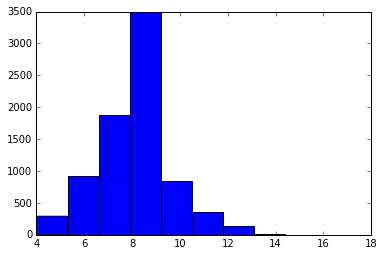

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(list(map(len, names)))

# max length of a name in this dataset
MAX_LEN = min([60, max(list(map(len, names)))])-1

print(MAX_LEN)

### Convert symbols to their ids

In [8]:
names_ix = list(map(lambda name: list(map(token_to_id.get, name + ')')), names))

for i in range(len(names_ix)):
    names_ix[i] = names_ix[i][:MAX_LEN+1] #crop too long
    
    if len(names_ix[i]) < MAX_LEN+1:
        names_ix[i] += [token_to_id[" "]]*(MAX_LEN+1 - len(names_ix[i])) #pad too short
        
assert len(set(map(len, names_ix))) == 1

names_ix = np.array(names_ix)

In [9]:
names_ix[:10]

array([[ 1,  5,  6,  5, 11,  5,  9, 16,  0,  3,  1,  1,  1,  1,  1,  1,  1],
       [ 1,  5,  6,  5, 11,  5, 13, 16,  0,  3,  1,  1,  1,  1,  1,  1,  1],
       [ 1,  5,  6,  6,  9,  0,  3,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
       [ 1,  5,  6,  6,  9, 29,  0,  3,  1,  1,  1,  1,  1,  1,  1,  1,  1],
       [ 1,  5,  6,  6, 13,  0,  3,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
       [ 1,  5,  6,  6, 13,  9,  0,  3,  1,  1,  1,  1,  1,  1,  1,  1,  1],
       [ 1,  5,  6,  6, 29,  0,  3,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
       [ 1,  5,  6, 13, 11,  5,  9, 16,  0,  3,  1,  1,  1,  1,  1,  1,  1],
       [ 1,  5,  6, 13, 11,  5, 13, 16,  0,  3,  1,  1,  1,  1,  1,  1,  1],
       [ 1,  5,  6, 13, 11,  5, 16,  9,  0,  3,  1,  1,  1,  1,  1,  1,  1]])

## Batch generator

In [10]:
def sample_batch(data, batch_size):
    
    rows = data[np.random.randint(0, len(data), size=batch_size)]
    x = rows[:, :-1]
    y = rows[:, 1:]
    
    count = lambda r: np.sum([id_to_token[t] != ' ' for t in r])
    lengths = list(map(count, x))
    
    return x, y, lengths

In [11]:
x, y, length = sample_batch(names_ix, 10)
y.shape

(10, 16)

## Visualisation

In [12]:
from IPython.display import clear_output
def show_losses(losses, info, mean_win=30):
    def running_mean(x, N):
        cumsum = np.cumsum(np.insert(x, 0, 0)) 
        return (cumsum[N:] - cumsum[:-N]) / N 

    if mean_win>0:
        plt.plot(losses, 'c')
        plt.plot(running_mean(losses, mean_win), 'b')
        loss = np.mean(losses[-mean_win:])
    else:
        plt.plot(losses)
        loss = losses[-1]

    plt.grid(True)
    plt.title("loss: %.2e | %s" % (loss, info))
    clear_output(True)
    plt.show();

### Function to generation a name

* Lets take seed phrase
* Predicting next token
* Next token is being sampled from model predicted distribution 
* Token is added to seed phrase
* Repeat (from step 2)

In [13]:
def generate_sample(sess, seed_phrase=None, N=MAX_LEN, n_snippets=1):
    
    if seed_phrase is None:
        seed_phrase = ' '
    elif seed_phrase[0].isalpha():
        seed_phrase = ' ' + seed_phrase
    seed_phrase = seed_phrase.lower()
    seed_phrase = np.array([token_to_id[tok] for tok in seed_phrase])
    L = len(seed_phrase)
    snippets = []
    for _ in range(n_snippets):
        x = np.zeros(N)
        x[:len(seed_phrase)] = seed_phrase
        for n in range(N - L):
            feed_dict = {X: x[:L + n].reshape([1, -1]), lengths: [len(x)]}
            p = sess.run(last_word_probas, feed_dict=feed_dict).reshape(-1)
            ix = np.random.choice(np.arange(len(tokens)), p=p)
            x[L + n] = ix
        snippet = ''.join([id_to_token[idx] for idx in x])
        if ')' in snippet:
            upto = snippet.index(')')
            snippet = snippet[:upto]
        snippets.append(snippet.strip().capitalize())
    return snippets

In [14]:
def get_tokens(tokens):
    return "".join([id_to_token[t] for t in tokens]).replace(' ', '.').replace('\n', '.').strip()

# Network inputs

In [39]:
reset_graph()

n_neurons       = 100
embedding_size  = 16
vocabulary_size = len(tokens)
n_steps         = MAX_LEN # this is number of unrollings


X = tf.placeholder(tf.int32, [None, None], name= 'X')
y = tf.placeholder(tf.int32, [None, None], name = 'y')
lengths = tf.placeholder(tf.float32, [None], name = 'lengths')
learning_rate_ph = tf.placeholder(dtype=tf.float32, shape=[])

embedding_mtx = tf.Variable(tf.random_normal(shape=[vocabulary_size, embedding_size], dtype=tf.float32), name='embedding_mtx')
embed = tf.nn.embedding_lookup(embedding_mtx, X)

#embed = tf.one_hot(X, vocabulary_size) 


num_layers = 2

cells = []
for _ in range(num_layers):
    cell = tf.contrib.rnn.LSTMCell(n_neurons)
    cells.append(cell)
cell = tf.contrib.rnn.MultiRNNCell(cells)

rnn_outputs, states = tf.nn.dynamic_rnn(cell, embed, dtype=tf.float32, sequence_length=lengths)

# make logits
pred_logits = tf.layers.dense(rnn_outputs, vocabulary_size)

stepwise_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
    labels = tf.one_hot(y, vocabulary_size),
    logits = pred_logits)
    
loss_op = tf.reduce_mean(stepwise_cross_entropy)

pred_probas = tf.nn.softmax(pred_logits)

# sampling predictions of size [batch_size, num_steps]
prediction = tf.argmax(pred_probas, axis=2)

train_op = tf.train.AdamOptimizer(learning_rate_ph).minimize(loss_op)

# get the probability distribution for the last symbol
# that will be needed for generation
last_word_probas = pred_probas[:, -1]

## Training

In [40]:
s = tf.Session()
s.run(tf.global_variables_initializer())
print(generate_sample(s, n_snippets=6))

['Gyrn-- vnq\nzuba', 'Aelidn-dgjtbln', "Na yyte'qi", "Pellaztywnx'b f", "Hdugdl-t'zsb\nuq", "Rs'f"]


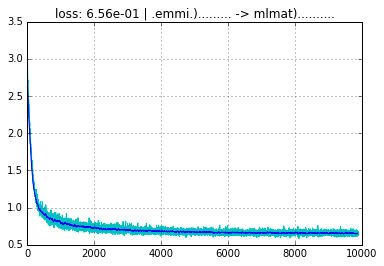

In [41]:
n_steps           = 10000
batch_size        = 32
lr                = 1e-2
try:
    losses = []
    for step in range(n_steps):
        x_, y_, len_ = sample_batch(names_ix, batch_size)
        _, loss_val, y_pred = s.run([train_op, loss_op, prediction],  feed_dict={
            X: x_,
            y: y_,
            lengths: len_,
            learning_rate_ph: lr})
        losses.append(loss_val)
        if step%100 == 0:
            info = "%s -> %s"%(get_tokens(x_[0]), get_tokens(y_pred[0]))
            show_losses(losses, info)

except KeyboardInterrupt:
    pass

In [42]:
print(", ".join(generate_sample(s, seed_phrase='Ang', n_snippets=32)))

Angelina, Angelin, Angil, Angleue, Angelera, Angiaco, Angie, Angile, Angil, Angelin, Angel, Angile, Angila, Angile, Angelina, Angiette, Angelea, Angile, Angelin, Angil, Angeline, Angelina, Angelin, Angil, Angeline, Angila, Angelita, Angeliga, Angelice, Angila, Angala, Angila
